In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets as tv_datasets
from torchvision import transforms, models

from datasets import load_dataset

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Root directories for this project
ROOT_DIR = "/content/houseplants"
RAW_IMG_DIR = os.path.join(ROOT_DIR, "images")
SPLIT_ROOT = os.path.join(ROOT_DIR, "splits")

os.makedirs(RAW_IMG_DIR, exist_ok=True)
os.makedirs(SPLIT_ROOT, exist_ok=True)

Device: cpu


In [2]:
ds = load_dataset("kakasher/house-plant-species", split="train")
print(ds)
print(ds[0]["__key__"])

from io import BytesIO
from PIL import Image

def decode_image(jpg_field):
    """Robustly decode the jpg field into a PIL RGB image.
       Returns None if the image is missing or invalid.
    """
    if jpg_field is None:
        return None

    if isinstance(jpg_field, Image.Image):
        return jpg_field.convert("RGB")

    if isinstance(jpg_field, (bytes, bytearray)):
        return Image.open(BytesIO(jpg_field)).convert("RGB")

    if isinstance(jpg_field, dict) and "bytes" in jpg_field:
        return Image.open(BytesIO(jpg_field["bytes"])).convert("RGB")

    print("Warning: unknown jpg type:", type(jpg_field))
    return None


records = []
skipped = 0

for i, ex in enumerate(ds):
    key = ex["__key__"]
    parts = key.split("/")
    label_name = parts[1]  # "Peace lily", "African Violet (...)", etc.

    img = decode_image(ex["jpg"])
    if img is None:
        skipped += 1
        continue

    filename = f"img_{i:05d}.jpg"
    img_path = os.path.join(RAW_IMG_DIR, filename)
    img.save(img_path)

    records.append({"image": filename, "label_name": label_name})

print("Total samples:", len(ds))
print("Saved images :", len(records))
print("Skipped      :", skipped)

df = pd.DataFrame(records)
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

house_plant_species.tar:   0%|          | 0.00/5.27G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['jpg', '__key__', '__url__'],
    num_rows: 14790
})
house_plant_species/African Violet (Saintpaulia ionantha)/200
Total samples: 14790
Saved images : 13362
Skipped      : 1428


,image,label_name
0,img_00000.jpg,African Violet (Saintpaulia ionantha)
1,img_00001.jpg,Chinese Money Plant (Pilea peperomioides)
2,img_00002.jpg,Peace lily
3,img_00003.jpg,Jade plant (Crassula ovata)
4,img_00004.jpg,Aloe Vera


In [3]:
unique_labels = sorted(df["label_name"].unique())
label_to_id = {name: idx for idx, name in enumerate(unique_labels)}
id_to_label = {v: k for k, v in label_to_id.items()}

df["label_id"] = df["label_name"].map(label_to_id)

num_classes = len(unique_labels)
print("Number of classes:", num_classes)
df.head()

Number of classes: 47


,image,label_name,label_id
0,img_00000.jpg,African Violet (Saintpaulia ionantha),0
1,img_00001.jpg,Chinese Money Plant (Pilea peperomioides),11
2,img_00002.jpg,Peace lily,31
3,img_00003.jpg,Jade plant (Crassula ovata),23
4,img_00004.jpg,Aloe Vera,1


In [4]:
from sklearn.model_selection import train_test_split

X = df["image"].values
y = df["label_id"].values

# First split 70 / 30
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Then split 30 into 15 / 15
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print(len(X_train), len(X_val), len(X_test))

9353 2004 2005


In [5]:
def export_split(img_names, labels, split_name):
    for img_name, label_id in zip(img_names, labels):
        label_name = id_to_label[label_id]    # human-readable class
        dst_dir = os.path.join(SPLIT_ROOT, split_name, label_name)
        os.makedirs(dst_dir, exist_ok=True)

        src = os.path.join(RAW_IMG_DIR, img_name)
        dst = os.path.join(dst_dir, img_name)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

export_split(X_train, y_train, "train")
export_split(X_val,   y_val,   "val")
export_split(X_test,  y_test,  "test")

print("ImageFolder structure created at:", SPLIT_ROOT)

IMG_SIZE = 224

transform_base = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

train_dataset = tv_datasets.ImageFolder(os.path.join(SPLIT_ROOT, "train"), transform=transform_base)
val_dataset   = tv_datasets.ImageFolder(os.path.join(SPLIT_ROOT, "val"),   transform=transform_base)
test_dataset  = tv_datasets.ImageFolder(os.path.join(SPLIT_ROOT, "test"),  transform=transform_base)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)

class_names_if = train_dataset.classes
print("Num classes:", len(class_names_if))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

try:
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
except Exception:
    resnet = models.resnet18(pretrained=True)

resnet.eval()
for p in resnet.parameters():
    p.requires_grad = False

feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)

def extract_features(dataloader, model, device):
    model.eval()
    feats_list, labels_list = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            feats = model(imgs)                 # (B, 512, 1, 1)
            feats = feats.view(feats.size(0), -1)
            feats_list.append(feats.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    X = np.concatenate(feats_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

print("Extracting features...")
X_train_feats, y_train_feats = extract_features(train_loader, feature_extractor, device)
X_val_feats,   y_val_feats   = extract_features(val_loader,   feature_extractor, device)
X_test_feats,  y_test_feats  = extract_features(test_loader,  feature_extractor, device)

print("Train:", X_train_feats.shape)
print("Val  :", X_val_feats.shape)
print("Test :", X_test_feats.shape)


ImageFolder structure created at: /content/houseplants/splits
Num classes: 47
Device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


Extracting features...
Train: (9353, 512)
Val  : (2004, 512)
Test : (2005, 512)


In [6]:
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_feats, y_train_feats)

print("Class counts before:", np.bincount(y_train_feats))
print("Class counts after :", np.bincount(y_train_bal))

param_grid = {
    "n_neighbors": [3, 5, 7, 11, 15],
    "weights": ["distance"],            # distance-weighting helps with imbalance
    "metric": ["euclidean", "manhattan"],
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train_bal, y_train_bal)

print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

best_knn = grid.best_estimator_

y_val_pred = best_knn.predict(X_val_feats)
val_acc = accuracy_score(y_val_feats, y_val_pred)
val_f1  = f1_score(y_val_feats, y_val_pred, average="macro")
print("Validation accuracy:", val_acc)
print("Validation macro-F1:", val_f1)

Class counts before: [221 156 301 113 108 146 113 194 191 209 166 244 326 197 133 215 283 161
 336 214 148 207 171 216  83 304 271 223 342 153 197 241 193 220 120 156
 255 198 176 135 191 233 213 225 132  42 281]
Class counts after : [342 342 342 342 342 342 342 342 342 342 342 342 342 342 342 342 342 342
 342 342 342 342 342 342 342 342 342 342 342 342 342 342 342 342 342 342
 342 342 342 342 342 342 342 342 342 342 342]
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV macro-F1: 0.8529895836074224
Validation accuracy: 0.6167664670658682
Validation macro-F1: 0.6079864814307085


In [7]:
y_test_pred = best_knn.predict(X_test_feats)

test_acc = accuracy_score(y_test_feats, y_test_pred)
test_f1  = f1_score(y_test_feats, y_test_pred, average="macro")

print("\nTEST RESULTS")
print("Accuracy:", test_acc)
print("Macro-F1:", test_f1)
print("\nClassification report:\n")
print(classification_report(y_test_feats, y_test_pred, target_names=class_names_if))


TEST RESULTS
Accuracy: 0.6249376558603491
Macro-F1: 0.6118045477368915

Classification report:

                                            precision    recall  f1-score   support

     African Violet (Saintpaulia ionantha)       0.87      0.83      0.85        48
                                 Aloe Vera       0.85      0.67      0.75        33
          Anthurium (Anthurium andraeanum)       0.86      0.74      0.79        65
             Areca Palm (Dypsis lutescens)       0.33      0.71      0.45        24
       Asparagus Fern (Asparagus setaceus)       1.00      0.48      0.65        23
                    Begonia (Begonia spp.)       0.48      0.32      0.38        31
     Bird of Paradise (Strelitzia reginae)       0.81      0.71      0.76        24
         Birds Nest Fern (Asplenium nidus)       0.43      0.59      0.49        41
        Boston Fern (Nephrolepis exaltata)       0.67      0.73      0.70        41
                                  Calathea       0.41      0.4

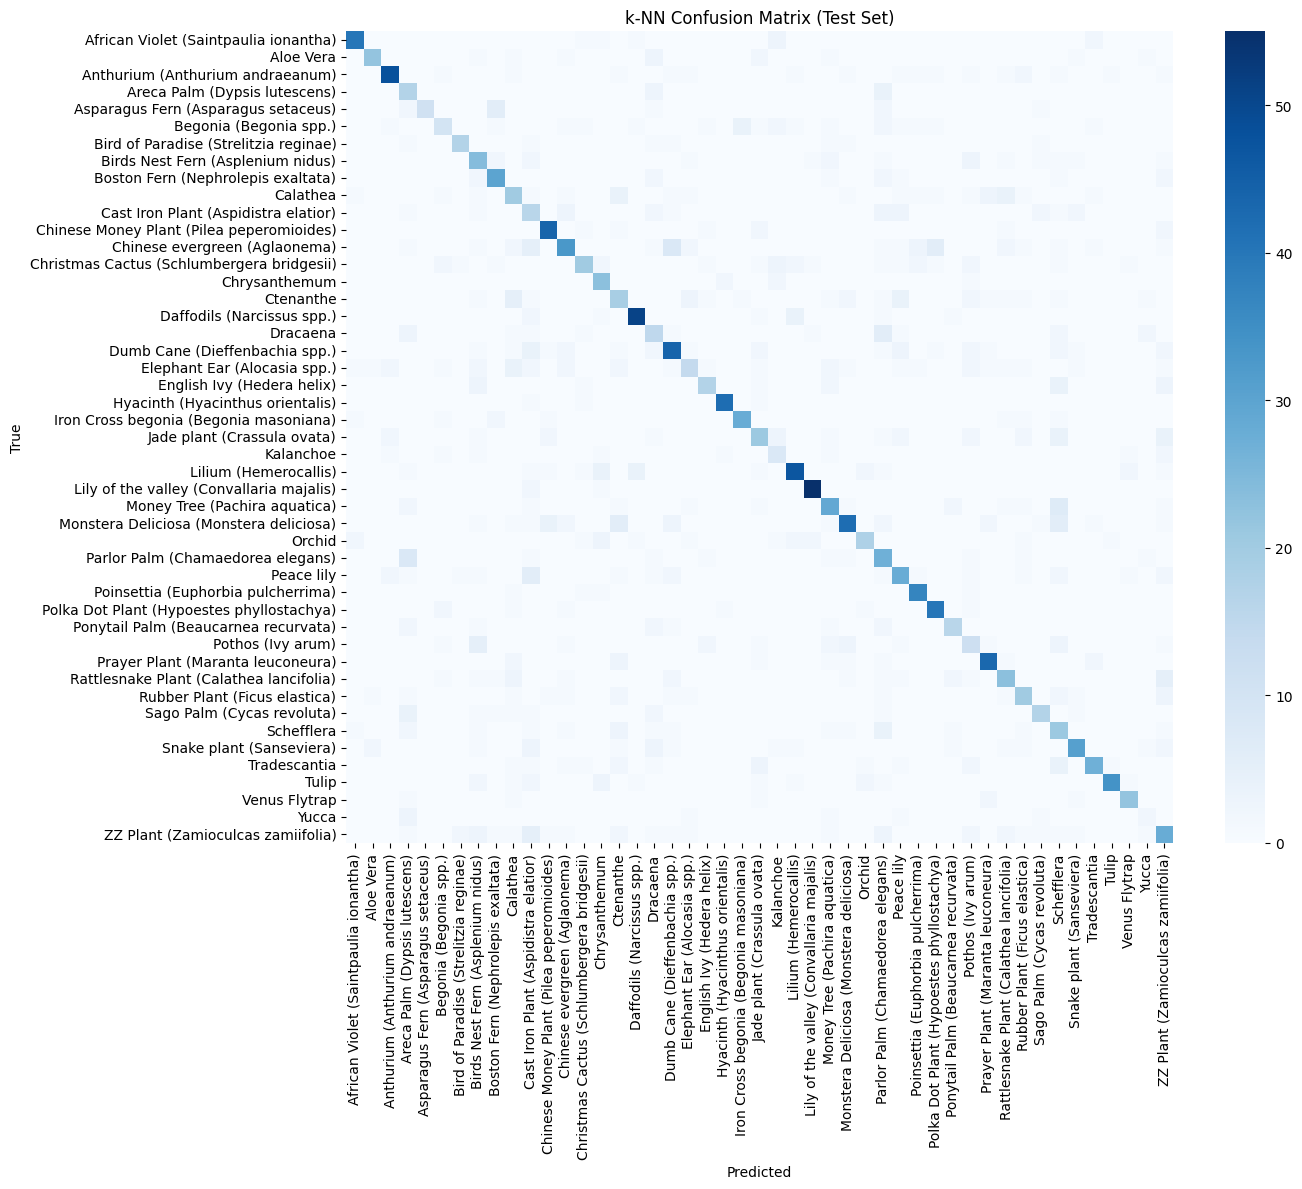

In [8]:
cm = confusion_matrix(y_test_feats, y_test_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names_if,
    yticklabels=class_names_if,
    annot=False
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("k-NN Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Predictions
y_val_pred  = best_knn.predict(X_val_feats)
y_test_pred = best_knn.predict(X_test_feats)

def summarize_split(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    f1_micro = f1_score(y_true, y_pred, average="micro")
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"=== {name} ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"F1 (macro)    : {f1_macro:.4f}")
    print(f"F1 (weighted) : {f1_weighted:.4f}")
    print(f"F1 (micro)    : {f1_micro:.4f}  (same as accuracy)")
    print(f"Precision(macro): {prec_macro:.4f}")
    print(f"Recall(macro)   : {rec_macro:.4f}")
    print()

summarize_split("Validation", y_val_feats, y_val_pred)
summarize_split("Test",       y_test_feats, y_test_pred)

=== Validation ===
Accuracy      : 0.6168
F1 (macro)    : 0.6080
F1 (weighted) : 0.6215
F1 (micro)    : 0.6168  (same as accuracy)
Precision(macro): 0.6234
Recall(macro)   : 0.6103

=== Test ===
Accuracy      : 0.6249
F1 (macro)    : 0.6118
F1 (weighted) : 0.6312
F1 (micro)    : 0.6249  (same as accuracy)
Precision(macro): 0.6329
Recall(macro)   : 0.6105



,class,precision,recall,f1,support
26,Lily of the valley (Convallaria majalis),0.916667,0.948276,0.932203,58
21,Hyacinth (Hyacinthus orientalis),0.913043,0.933333,0.923077,45
0,African Violet (Saintpaulia ionantha),0.869565,0.833333,0.851064,48
16,Daffodils (Narcissus spp.),0.864407,0.836066,0.850000,61
32,Poinsettia (Euphorbia pulcherrima),0.787234,0.902439,0.840909,41
11,Chinese Money Plant (Pilea peperomioides),0.800000,0.846154,0.822430,52
33,Polka Dot Plant (Hypoestes phyllostachya),0.784314,0.851064,0.816327,47
22,Iron Cross begonia (Begonia masoniana),0.848485,0.777778,0.811594,36
2,Anthurium (Anthurium andraeanum),0.857143,0.738462,0.793388,65
43,Tulip,0.918919,0.693878,0.790698,49


,class,precision,recall,f1,support
9,Calathea,0.408163,0.444444,0.425532,45
15,Ctenanthe,0.387755,0.413043,0.400000,46
24,Kalanchoe,0.347826,0.470588,0.400000,17
40,Schefflera,0.318182,0.512195,0.392523,41
17,Dracaena,0.348837,0.441176,0.389610,34
5,Begonia (Begonia spp.),0.476190,0.322581,0.384615,31
19,Elephant Ear (Alocasia spp.),0.500000,0.304348,0.378378,46
35,Pothos (Ivy arum),0.324324,0.363636,0.342857,33
10,Cast Iron Plant (Aspidistra elatior),0.262295,0.457143,0.333333,35
45,Yucca,0.222222,0.222222,0.222222,9


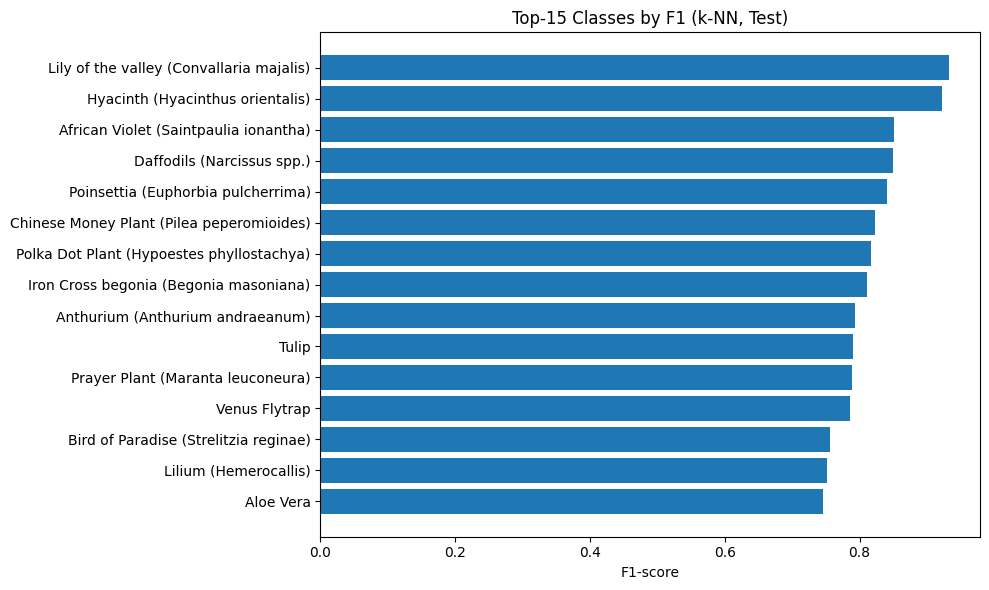

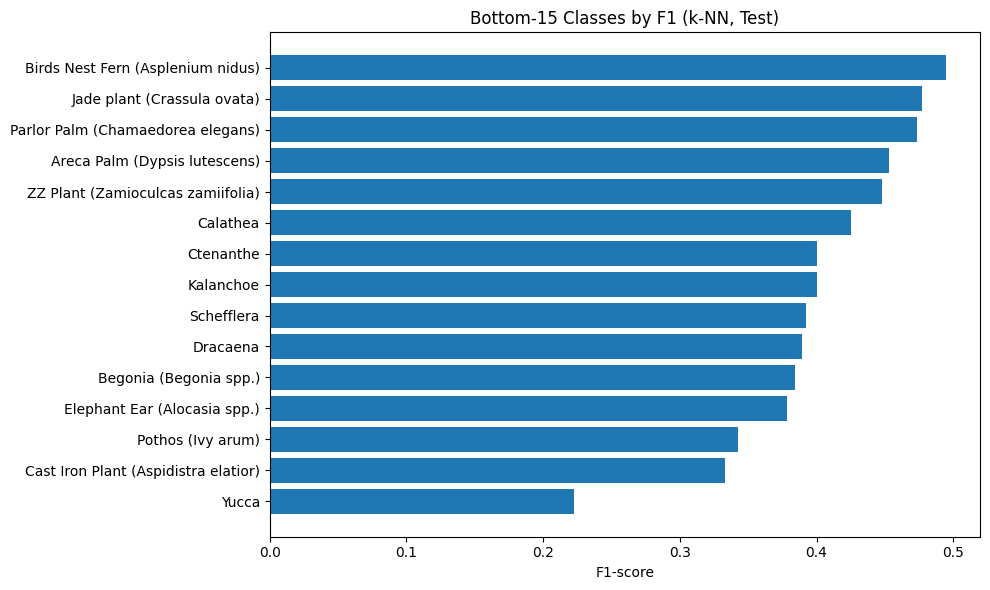

In [10]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, sup = precision_recall_fscore_support(
    y_test_feats, y_test_pred, labels=list(range(len(class_names_if))), zero_division=0
)

metrics_df = pd.DataFrame({
    "class": class_names_if,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": sup
}).sort_values("f1", ascending=False)

display(metrics_df.head(10))
display(metrics_df.tail(10))

top_k = 15
bottom_k = 15

plt.figure(figsize=(10, 6))
plt.barh(metrics_df.head(top_k)["class"][::-1], metrics_df.head(top_k)["f1"][::-1])
plt.xlabel("F1-score")
plt.title(f"Top-{top_k} Classes by F1 (k-NN, Test)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(metrics_df.tail(bottom_k)["class"][::-1], metrics_df.tail(bottom_k)["f1"][::-1])
plt.xlabel("F1-score")
plt.title(f"Bottom-{bottom_k} Classes by F1 (k-NN, Test)")
plt.tight_layout()
plt.show()

In [12]:
cm = confusion_matrix(y_test_feats, y_test_pred)
np.fill_diagonal(cm, 0)

pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0:
            pairs.append((cm[i, j], i, j))

pairs.sort(reverse=True, key=lambda x: x[0])
top_n = 15

print(f"Top-{top_n} confusions (True -> Predicted):")
for c, i, j in pairs[:top_n]:
    print(f"{c:4d} : {class_names_if[i]}  ->  {class_names_if[j]}")

Top-15 confusions (True -> Predicted):
   8 : Chinese evergreen (Aglaonema)  ->  Dumb Cane (Dieffenbachia spp.)
   8 : Parlor Palm (Chamaedorea elegans)  ->  Areca Palm (Dypsis lutescens)
   7 : Money Tree (Pachira aquatica)  ->  Schefflera
   6 : Asparagus Fern (Asparagus setaceus)  ->  Boston Fern (Nephrolepis exaltata)
   6 : Chinese evergreen (Aglaonema)  ->  Polka Dot Plant (Hypoestes phyllostachya)
   6 : Dracaena  ->  Parlor Palm (Chamaedorea elegans)
   6 : Monstera Deliciosa (Monstera deliciosa)  ->  Ctenanthe
   6 : Monstera Deliciosa (Monstera deliciosa)  ->  Schefflera
   6 : Peace lily  ->  Cast Iron Plant (Aspidistra elatior)
   5 : Chinese evergreen (Aglaonema)  ->  Cast Iron Plant (Aspidistra elatior)
   5 : Ctenanthe  ->  Calathea
   5 : Pothos (Ivy arum)  ->  Birds Nest Fern (Asplenium nidus)
   5 : Rattlesnake Plant (Calathea lancifolia)  ->  ZZ Plant (Zamioculcas zamiifolia)
   5 : ZZ Plant (Zamioculcas zamiifolia)  ->  Cast Iron Plant (Aspidistra elatior)
   4 : Ar

In [13]:
results_knn = {
    "Model": "k-NN (ResNet18 feats, oversample + dist-weight)",
    "Best Params": str(best_knn.get_params()),
    "Test Accuracy": float(accuracy_score(y_test_feats, y_test_pred)),
    "Test Macro-F1": float(f1_score(y_test_feats, y_test_pred, average="macro")),
    "Test Weighted-F1": float(f1_score(y_test_feats, y_test_pred, average="weighted")),
}

pd.DataFrame([results_knn])

,Model,Best Params,Test Accuracy,Test Macro-F1,Test Weighted-F1
0,"k-NN (ResNet18 feats, oversample + dist-weight)","{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.624938,0.611805,0.63122
